In [1]:
!pip install tensorflow==2.16.1
!pip install keras==3.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 50.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.4 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    Fo

In [10]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import string
import re
import unicodedata
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
# Load data
data = pd.read_csv("chat_health.csv")
data = data.head(50)

# Define function to convert unicode to ASCII
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

# Define text cleaning function
def clean_text(text):
    text = unicode_to_ascii(text.lower().strip())
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\r", "", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "that is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"n'", "ng", text)
    text = re.sub(r"'bout", "about", text)
    text = re.sub(r"'til", "until", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub("(\\W)"," ",text)
    text = re.sub('\S*\d\S*\s*','', text)
    return text

data["short_question"] = data.short_question.apply(clean_text)
data["short_answer"] = data.short_answer.apply(clean_text)

# Text preprocessing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['short_question'].tolist() + data['short_answer'].tolist())
vocab_size = len(tokenizer.word_index) + 1

questions_seq = tokenizer.texts_to_sequences(data['short_question'])
answers_seq = tokenizer.texts_to_sequences(data['short_answer'])

max_length = max(max(len(x) for x in questions_seq), max(len(x) for x in answers_seq))
questions_padded = pad_sequences(questions_seq, maxlen=max_length, padding='post')
answers_padded = pad_sequences(answers_seq, maxlen=max_length, padding='post')

# Split dataset
train_questions, val_questions, train_answers, val_answers = train_test_split(
    questions_padded, answers_padded, test_size=0.1, random_state=42)

# Prepare training and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_questions, train_answers))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(16).repeat()

val_dataset = tf.data.Dataset.from_tensor_slices((val_questions, val_answers))
val_dataset = val_dataset.batch(16).repeat()

# Build model
model = Sequential([
    Embedding(vocab_size, 128),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    BatchNormalization(),
    Bidirectional(LSTM(256, return_sequences=True)),
    Dropout(0.5),
    Dense(vocab_size, activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adjust batch_size or directly use the entire dataset
batch_size = 16
class CombinedStoppingCallback(Callback):
    def __init__(self, loss_threshold=0.01, improvement_threshold=0.01, patience=200):
        super(CombinedStoppingCallback, self).__init__()
        self.loss_threshold = loss_threshold  # Stop training if loss is below this value
        self.improvement_threshold = improvement_threshold  # Consider stopping if improvement is less than this value
        self.patience = patience  # Max consecutive epochs to wait before deciding to stop
        self.best_loss = float('inf')
        self.best_epoch = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('loss')
        if current_loss is None:
            return

        # Check if the loss has reached below the threshold
        if current_loss < self.loss_threshold:
            print(f"\nEpoch {epoch}: Stopping training as loss {current_loss} is below threshold {self.loss_threshold}.")
            self.model.stop_training = True

        # Check if there is a significant improvement in loss
        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.best_epoch = epoch
        else:
            # Check if it has been 'patience' epochs since the last best loss and the improvement is not enough
            if (epoch - self.best_epoch) >= self.patience and (self.best_loss - current_loss) < self.improvement_threshold:
                print(f"\nEpoch {epoch}: No significant improvement in loss for {self.patience} epochs. Stopping training.")
                self.model.stop_training = True

# Create an instance of CombinedStoppingCallback
stopping_callback = CombinedStoppingCallback(loss_threshold=0.1, improvement_threshold=0.01, patience=100)

# Use the model and save training history
history = model.fit(
    train_dataset,
    epochs=2000,
    steps_per_epoch=max(1, len(train_questions) // batch_size),
    validation_data=val_dataset,
    validation_steps=max(1, len(val_questions) // batch_size),
    callbacks=[stopping_callback]
)

Epoch 1/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.0841 - loss: 6.4953 - val_accuracy: 0.5474 - val_loss: 6.3314
Epoch 2/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4487 - loss: 5.6643 - val_accuracy: 0.5509 - val_loss: 5.2587
Epoch 3/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 865ms/step - accuracy: 0.4431 - loss: 4.4017 - val_accuracy: 0.5193 - val_loss: 3.6824
Epoch 4/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4609 - loss: 4.1604 - val_accuracy: 0.5404 - val_loss: 3.4735
Epoch 5/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.5236 - loss: 3.5484 - val_accuracy: 0.5509 - val_loss: 3.4989
Epoch 6/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 890ms/step - accuracy: 0.5497 - loss: 3.4026 - val_accuracy: 0.5474 - val_loss: 3.5190
Epoch 7/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.4678 - loss: 3.8258 - val_accuracy: 0.5474 - val_loss: 3.6239
Epoch 8/2000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.5758 - loss: 3.0685 - val_accuracy: 0.5474 - val_loss: 

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 57, 128)             │          88,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 57, 512)             │         788,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 57, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 57, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 57, 512)             │       1,574,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 57, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 57, 691)             │         354,483 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,423,067 (32.13 MB)

 Trainable params: 2,807,347 (10.71 MB)

 Non-trainable params: 1,024 (4.00 KB)

 Optimizer params: 5,614,696 (21.42 MB)

In [ ]:
# Save the model to an HDF5 file
model.save('model_LSTM_50.h5')

# save Tokenizer
import pickle
with open('tokenizer_LSTM_50.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model
import pickle

# load model
model = load_model('model_LSTM_50.h5')

# load Tokenizer
with open('tokenizer_LSTM_50.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)


In [13]:
# generate answer
def generate_answer(question,model):
    question_seq = tokenizer.texts_to_sequences([question])
    question_padded = pad_sequences(question_seq, maxlen=max_length, padding='post')
    prediction = model.predict(question_padded)
    predicted_indices = np.argmax(prediction, axis=-1)[0]
    predicted_words = ' '.join([tokenizer.index_word[i] for i in predicted_indices if i != 0])
    return predicted_words

In [12]:
testData = pd.read_csv('chat_health.csv').head(50)

In [14]:
from nltk.translate.bleu_score import corpus_bleu
testData['generated_answer'] = testData['short_question'].apply(lambda q: generate_answer(q, model))

references = testData['short_answer'].apply(lambda a: [a.split()]).tolist()
candidates = testData['generated_answer'].apply(lambda a: a.split()).tolist()

bleu_score = corpus_bleu(references, candidates)
print("BLEU Score:", bleu_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━

In [ ]:
import time
start_time = time.time()
testData['generated_answer'] = testData['short_question'].head(50).apply(lambda q: generate_answer(q, model))
end_time = time.time()
response_time = end_time - start_time
average_response_time = response_time / 50

print(f"Average response time per record: {average_response_time} seconds")

1/1 [==============================] - 0s 72ms/step
Average response time per record: 0.16572951316833495 seconds


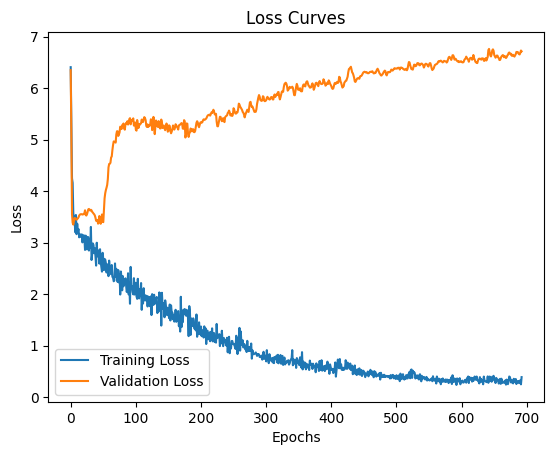

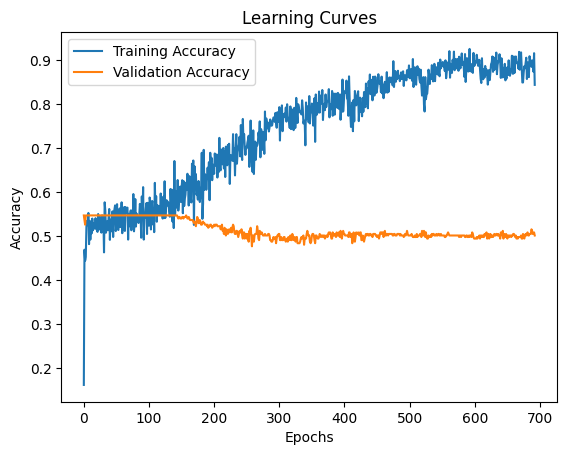

In [ ]:
import matplotlib.pyplot as plt
# Plotting loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curves')
plt.show()

# Plotting accuracy curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curves')
plt.show()